<a href="https://colab.research.google.com/github/Shritej24c/NLP101/blob/main/HW/HW7/ShritejShrikant_Chavan_HW_7_PartA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color = 'indianred'>**HW7_Handling_Longer_Sequences_Class_Imbalance: 20 Points** </font>


Homework 7 Instructions
In this assignment, you'll work with the StackExchange dataset from HW5, focusing on `basic_cleaned_text` and `Tag_Number_final`.
Changes from HW5
1. Data Filtering: Select rows from `basic_cleaned_text` with a word count > 400 (about 4000 samples).
2. Custom Collate Function: Develop a function for handling longer sequences. Break the document into smaller chunks (sub-parts).
3. Subclass Trainer:
   - Modify the `custom_loss` function for longer sequences and class imbalance.
   - For calculating loss, take the log probabilities for each chunk and average them to get document-level log probabilities, which should be used in your loss function.  
4. Aggregation Function: Create a function for aggregating predictions. - Similar to the loss function, make predictions based on aggregated log probabilities from chunks.
5. Evaluation Method: With the implementation of chunking, Trainer.Predict will become incompatible. Write your own function for evaluations.
Reference Files: Use `2_MultiClass_imbalanced_custom_Trainer.ipynb` and `4_imdb_bert_longer_seq_sliding_window_detailed.ipynb` from the `Final_files` in Lecture 10 folder.

In [1]:
 # CHANGE FOLDERS AS PER YOUR SETUP
from pathlib import Path
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount("/content/drive")
    !pip install datasets transformers evaluate wandb accelerate -U -qq
    base_folder = Path("/content/drive/MyDrive/NLP")
else:
    base_folder = Path("/home/harpreet/Insync/google_drive_shaannoor/data")


from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from transformers import AutoTokenizer, DataCollatorWithPadding, pipeline
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
import evaluate

import torch
from torch.utils.data import DataLoader

import wandb

import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random

import textwrap

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 107.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 89.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 105.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 30.5 MB/s eta 0:

In [2]:
# CHANGE FOLDERS TO WHERE YOU WANT TO SAVE DATA AND MODELS
data_folder = base_folder/'datasets/Classification_HW/csv_files'
model_folder = base_folder/'models/nlp_spring_2023/HW7'
model_folder.mkdir(exist_ok=False)

In [3]:
def print_wrap(text, d):
    # Wrap the text to limit the width to 'd'
    wrapped_text = textwrap.fill(text, width=d)

    # Print the wrapped text
    print(wrapped_text)

# <font color = 'indianred'> **Exploring and Understanding Dataset**

## <font color = 'indianred'> **Stack Exchange MultiClass Dataset**</font>

- In this HW, you will identify tags for stack exchange Questions.
- This data is a subset of data available in a Kaggle Competition.
- The given dataset has different questions asked in the StackExchange website for various technical domains.
- We have fetched only those questions that contain the top 10 individual tags.
- **Each question has only one tag. This means that this is a <font color = "indianred">multi-class classification problem.**</font>
- These are the ten categories for tags in the data.

<div style="margin-left:5%">


| Index| Tag  |
|:-------:|:-------------:|
| 0     | C#          |
| 1     | java        |
| 2     | php         |
| 3     | javascript  |
| 4     | android     |
| 5     | jquery      |
| 6     | c++         |
| 7     | python      |
| 8     | iphone      |
| 9     | asp.net     |

</div>

## <font color = 'indianred'> **Load Data set**
    


In [5]:
# The file 'multiclass_hw_basic_clean.csv' is availaible on e-Learning 0_data_Folder
# Make sure that you specify the correct path
# The file name need to be in the string, thaat is why we have used str(file_path)
# We loaded imdb dataset from huggingface
# in this case we are creating a hugginmgface dataset from csv file
stack_dataset = load_dataset('csv', data_files= str(data_folder /'multiclass_hw_basic_clean.csv'))

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

## <font color = 'indianred'> **Understanding your data**

In [6]:
print(stack_dataset)

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0.1', 'Unnamed: 0', 'Title', 'Body', 'cleaned_text', 'Tags', 'Tag_Number_final', 'combined_text', 'basic_cleaned_text'],
        num_rows: 188878
    })
})


## <font color = 'indianred'> **Understanding the datatype of columns**


In [7]:
stack_dataset['train'].features

{'Unnamed: 0.1': Value(dtype='int64', id=None),
 'Unnamed: 0': Value(dtype='int64', id=None),
 'Title': Value(dtype='string', id=None),
 'Body': Value(dtype='string', id=None),
 'cleaned_text': Value(dtype='string', id=None),
 'Tags': Value(dtype='string', id=None),
 'Tag_Number_final': Value(dtype='int64', id=None),
 'combined_text': Value(dtype='string', id=None),
 'basic_cleaned_text': Value(dtype='string', id=None)}

 - As you can see the dataset has lot of faeatures. However they are not all useful.
 - Title is the title of the stack exchange post
 - Body is the main text of the post
 - combined_text is Title and Body combined with no pre-processing
 - basic_cleaned_text is Title and Body combined with basic preprocessing (remove html tags, urls, emails).
 - cleaned_text - Here we have combined Body and Text and has done some motre pre-propcessing in addition to basic (removing stopwords, lammetization)
 - Tags - names of programming language to which the post belongs
 - Tag_Number_final - index corresponding to Tags

 - **Your goal in this HW is to predict Tags given Body and Title of the post**
 - **You will use Tag_Number_final and basic_cleaned_text for this HW**


## <font color = 'indianred'> **Acess indivdual element** </font>


In [8]:
# Assuming 'stack_dataset' is a huggingface dataset
# Select only the desired columns and rename them
selected_columns = {
    'text': stack_dataset['train']['basic_cleaned_text'],
    'label': stack_dataset['train']['Tag_Number_final']
}

# Create a new dataset with the selected columns
stack_selected_columns = Dataset.from_dict(selected_columns)


In [9]:
stack_selected_columns

Dataset({
    features: ['text', 'label'],
    num_rows: 188878
})

In [10]:
stack_selected_columns.features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

In [11]:
stack_selected_columns['label'][:10]

[8, 4, 3, 9, 4, 0, 3, 2, 0, 7]

In [12]:
print_wrap(stack_selected_columns['text'][0], 80)

detail disclosure indicator on UIButton Is there a simple way to place a detail
disclosure icon on a UIButton? I'm using a navigation controller and I want a
button press to push a new view on the stack, so I thought a detail disclosure
icon would be appropriate, but I haven't found a straightforward way to do that
yet. What I have in mind is something like the "When Timer Ends" button in the
Timer subview of the Clock app.


In [14]:
stack_selected_columns

Dataset({
    features: ['text', 'label'],
    num_rows: 188878
})

## <font color = 'indianred'> **Exploratory Data Analysis (EDA)**

### <font color = 'indianred'> **Change dataset format to Pandas**  </font>


In [27]:
# Set the format to Pandas
# CODE HERE

stack_selected_columns.set_format(type='pandas')


In [28]:
# get all rows the dataset
df = stack_selected_columns[:]


In [29]:
df.head()

,text,label
0,detail disclosure indicator on UIButton Is the...,8
1,hello world fails to show up in emulator I fol...,4
2,"Why is JSHint throwing a ""possible strict viol...",3
3,Programmatically Make Bound Column Invisible I...,9
4,"More than one EditText - not getting focus, no...",4


In [30]:
# DO NOT RUN THIS CELL

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188878 entries, 0 to 188877
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    188874 non-null  object
 1   label   188878 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.9+ MB


In [32]:
# DO NOT RUN THIS CELL

### <font color = 'indianred'> **Visualize distribution of class labels** </font>
It is important to undetrstand the distribution of the class labels to check if there is any imbalance among the categories.

<Axes: >

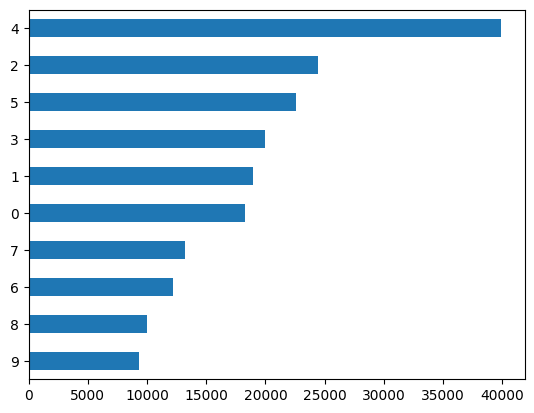

In [33]:
# Plot a horizontal bar chart showing the count of each unique value in the 'label' column of the dataframe 'df'.
# The counts are displayed in ascending order for better visualization of the distribution.
# CODE HERE
# check distribution of class labels in training dataset
df['label'].value_counts(ascending=True).plot.barh()

In [34]:
# DO NOT RUN THIS CELL

**Conclusions:**

From the above figure, we can clearly see the imbalance between labels. The most of the questions are of 'Android' Language and least from 'asp.net'


### <font color = 'indianred'> **Check length of the reviews** </font>


In [35]:
# Add empty strings for rows that do not have any text
df['text'] = df['text'].fillna('')

In [36]:
# Add a new column to the dataframe 'df' named 'words_per_review'.
# This column computes the number of words in each review in the 'text' column by splitting the text on spaces and counting the resulting words.
df['words_per_review'] = df['text'].apply(lambda x : len(x.split(' '))) # CODEE HERE



In [37]:
df.head()

,text,label,words_per_review
0,detail disclosure indicator on UIButton Is the...,8,81
1,hello world fails to show up in emulator I fol...,4,266
2,"Why is JSHint throwing a ""possible strict viol...",3,42
3,Programmatically Make Bound Column Invisible I...,9,62
4,"More than one EditText - not getting focus, no...",4,200


In [38]:
# DO NOT RUN THIS CELL

#### <font color = 'indianred'> **Plot the distribution of review length** </font>

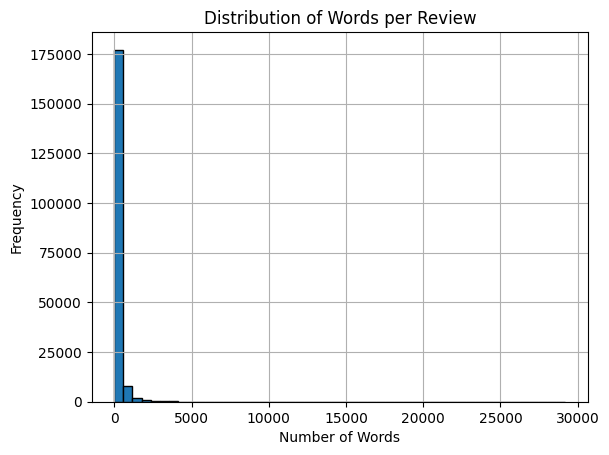

In [39]:
# Plot a histogram of the 'words_per_review' column
df['words_per_review'].hist(bins=50, edgecolor='black')

# Adding labels and a title for clarity
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Words per Review')

# Display the plot
plt.show()


In [40]:
# The model we are going to use has token (subwords) limit of 512.
# Let us check how many reviews has more than 500 words

count = (df['words_per_review'] > 500).sum()
print(f"Number of reviews with more than 500 words: {count}")


Number of reviews with more than 500 words: 14769


In [41]:
# count the rows that do not have any text
count = (df['words_per_review'] ==0).sum()
print(f"Number of reviews with no text words: {count}")

Number of reviews with no text words: 0


In [42]:
# check the rows that have less than 20 words
count = (df['words_per_review'] <20).sum()
print(f"Number of reviews with less than 20 words: {count}")

Number of reviews with less than 20 words: 1608


<Axes: title={'center': 'words_per_review'}, xlabel='label'>

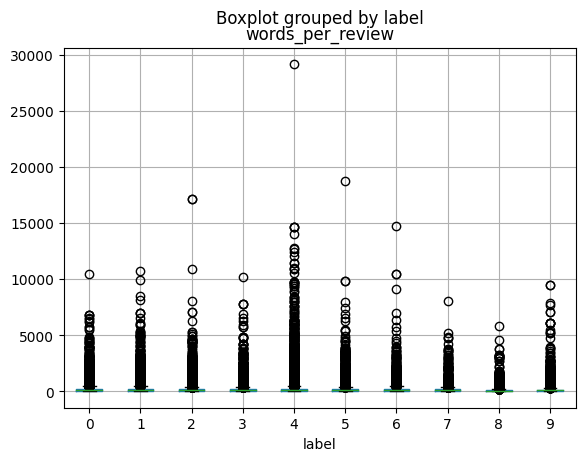

In [43]:
# distribution of number of words for each class label
df.boxplot('words_per_review', by='label')


- From the above graph, it seems that the distribution of number of words is similar for all the classes.
- Most models have max sequence length of 512. We have less than 1% observatins that have more than 512 words.

### <font color = 'indianred'> **Reset dataset format** </font>


In [44]:
# reset the format back to huggingface dataset
stack_selected_columns.reset_format()
# CODE HERE


# <font color = 'pickle'> **Data Pre-processing**</font>

## <font color = 'pickle'> **Filtering Larger Reviews**</font>

In [61]:
sum([1 if i is None else 0 for i in stack_selected_columns[:]['text']])

4

In [68]:
# Filter samples with more than 400 words
def filter_long_samples(example):

    return example['text'] is not None and len(example['text'].split()) > 400

stack_selected_columns = stack_selected_columns.filter(filter_long_samples)

Filter:   0%|          | 0/188878 [00:00<?, ? examples/s]

### <font color = 'indianred'> **Create train, valid, test splits** </font>

In [70]:
# We know this information from how we created this dataset
class_names = ['c#', 'java', 'php','javascript', 'android', 'jquery', 'c++',  'python', 'iphone', 'asp.net']

In [71]:
# Cast the 'label' column of stack_selected_columns to the ClassLabel type with specified class names from class_names.
stack_selected_columns = stack_selected_columns.cast_column('label', ClassLabel(names = class_names))


Casting the dataset:   0%|          | 0/4772 [00:00<?, ? examples/s]

The code above modifies the label column of the stack_selected_columns data structure to represent categorical data using the class names provided in class_names. This will help us to keep the index and names mapping together.

In [72]:
stack_selected_columns.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['c#', 'java', 'php', 'javascript', 'android', 'jquery', 'c++', 'python', 'iphone', 'asp.net'], id=None)}

In [73]:
stack_selected_columns

Dataset({
    features: ['text', 'label'],
    num_rows: 4772
})

In [74]:
# Split the 'stack_selected_columns' dataset into training, validation, and test sets.
# The aim is to have 60% for training, 20% for validation, and 20% for testing.

# First, split the dataset into a 60% training set and a 40% temporary set (to be further split).
# Use stratified sampling based on the 'label' column to ensure that each split has a similar distribution of labels.
test_val_splits = stack_selected_columns.train_test_split(test_size= 0.4, seed=21, stratify_by_column='label') # CODE HERE

# Extract the 60% training dataset.
train_split = test_val_splits["train"] #CODE HERE


# Split the 40% temporary set into two equal parts: validation (20%) and test (20%).
# Again, use stratified sampling based on the 'label' column.
test_val_splits =  test_val_splits["test"].train_test_split(test_size= 0.5, seed=21, stratify_by_column='label') #CODE HERE

# Extract the validation and test datasets.
val_split = test_val_splits['train']# CODE HERE
test_split = test_val_splits['test'] # CODE HERE



In [75]:
stack_selected_columns_dict = DatasetDict({'train': train_split, 'val': val_split, 'test': test_split})

In [77]:
# combine train, val splits into one dataset
train_val_subset= DatasetDict({'train': train_split, 'val': val_split})

# create test dataset from test split
test_subset = DatasetDict({'test': test_split})



### <font color = 'pickle'> **Create subset for experimentation** </font>

In [79]:
train_split_small = train_split.shuffle(seed=42).select(range(10))
val_split_small = val_split.shuffle(seed=42).select(range(10))
test_split_small = test_split.shuffle(seed=42).select(range(10))


In [80]:
train_val_subset.set_format(type='pandas')

In [81]:
df_train = train_val_subset['train'][:]

<Axes: >

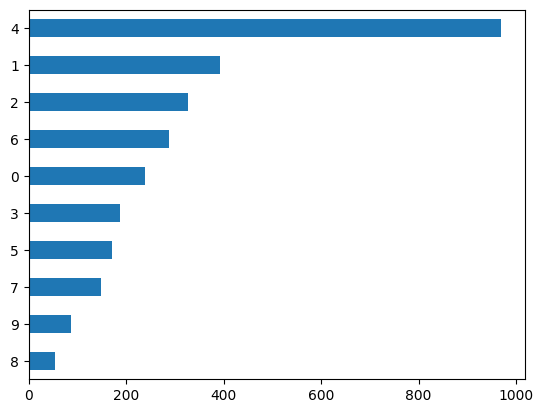

In [82]:
# check ditsribution of class labels in training dataset
df_train['label'].value_counts(ascending=True).plot.barh()